In [ ]:
# --- Statistical & Time Series Libraries ---
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
# --- Evaluation Metrics ---
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import itertools
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#Set default figure size for all plots to 10 inches wide by 7.5 inches tall
plt.rcParams['figure.figsize'] = [10, 7.5]

In [181]:
# read in data file
data = pd.read_csv('jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


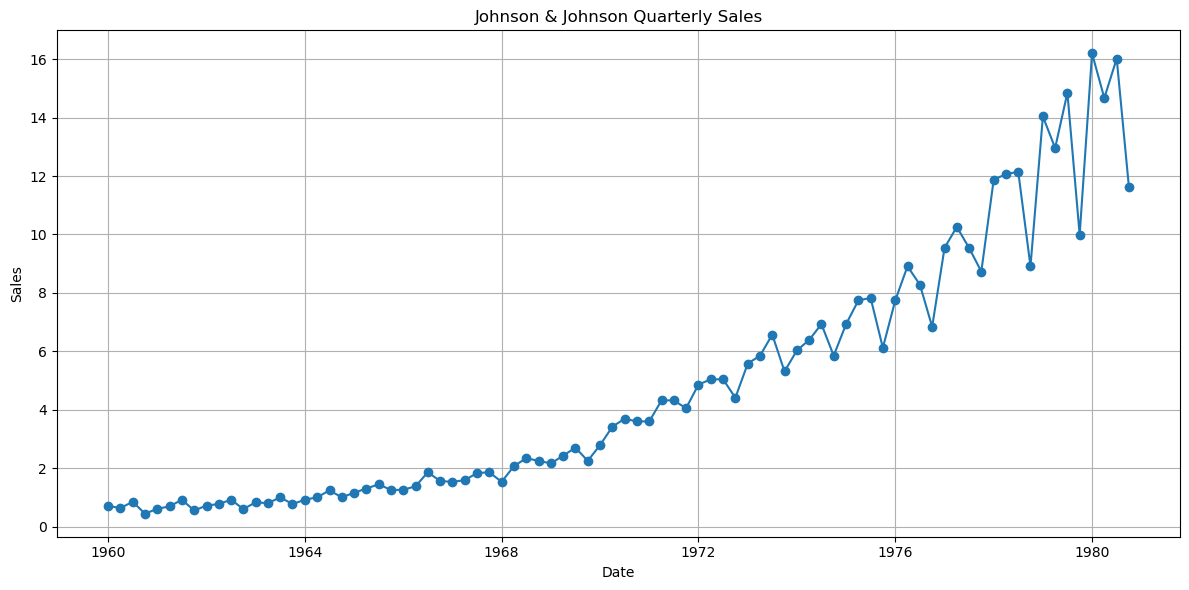

In [182]:
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['data'], marker='o')
plt.title('Johnson & Johnson Quarterly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


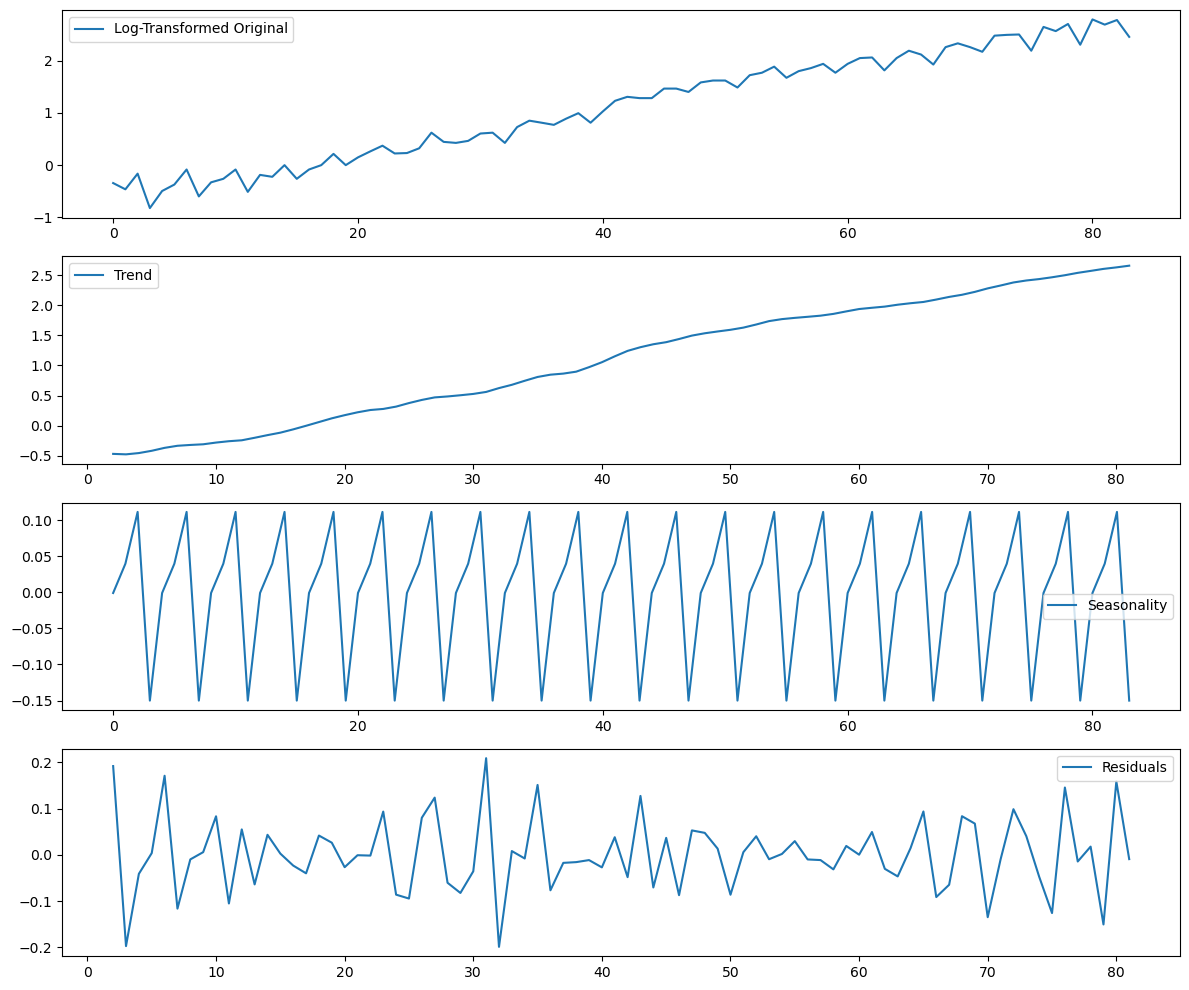

In [ ]:
#Apply log transformation
log_data = np.log(data['data'])

# Perform seasonal decomposition
decomposition = seasonal_decompose(log_data, model='additive', period=4)  # Quarterly data → period=4
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(log_data, label='Log-Transformed Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

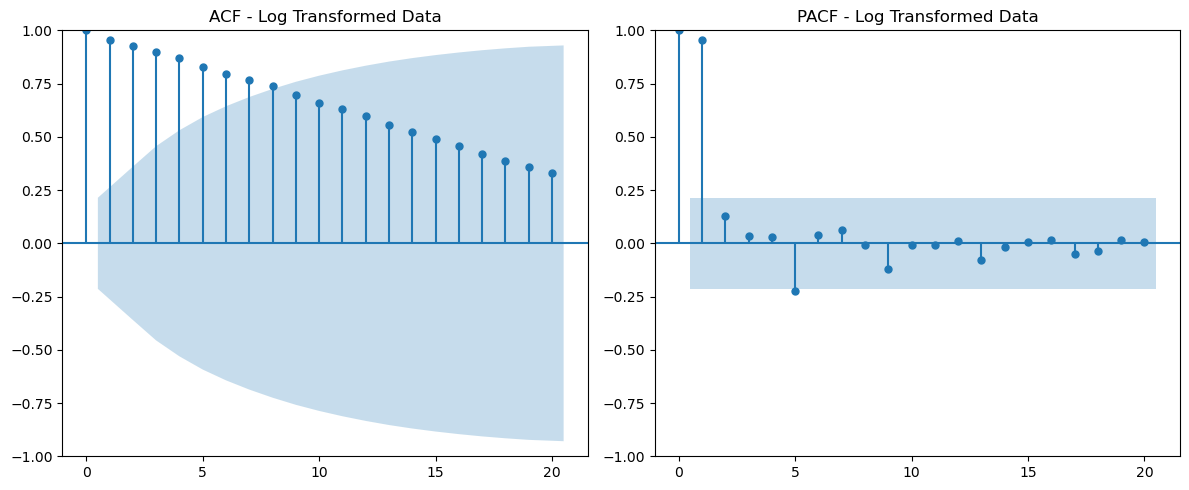

In [ ]:
# Drop NA values caused by decomposition (trend/residual missing at ends)
log_data_clean = log_data.dropna()

# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(log_data_clean, lags=20, ax=plt.gca())
plt.title('ACF - Log Transformed Data')
plt.subplot(1, 2, 2)
plot_pacf(log_data_clean, lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF - Log Transformed Data')
plt.tight_layout()
plt.show()

In [ ]:
# perform this on the original data. What does the p-value tell us

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


In [ ]:
# take the log()
data['data_log'] = np.log(data['data'])

# then take the first difference
data['data_tr_1'] = data['data_log'].diff()
data.head(10)

,date,data,data_log,data_tr_1
0,1960-01-01,0.71,-0.342490,NaN
1,1960-04-01,0.63,-0.462035,-0.119545
2,1960-07-02,0.85,-0.162519,0.299517
3,1960-10-01,0.44,-0.820981,-0.658462
4,1961-01-01,0.61,-0.494296,0.326684
5,1961-04-02,0.69,-0.371064,0.123233
6,1961-07-02,0.92,-0.083382,0.287682
7,1961-10-01,0.55,-0.597837,-0.514455
8,1962-01-01,0.72,-0.328504,0.269333
9,1962-04-02,0.77,-0.261365,0.067139


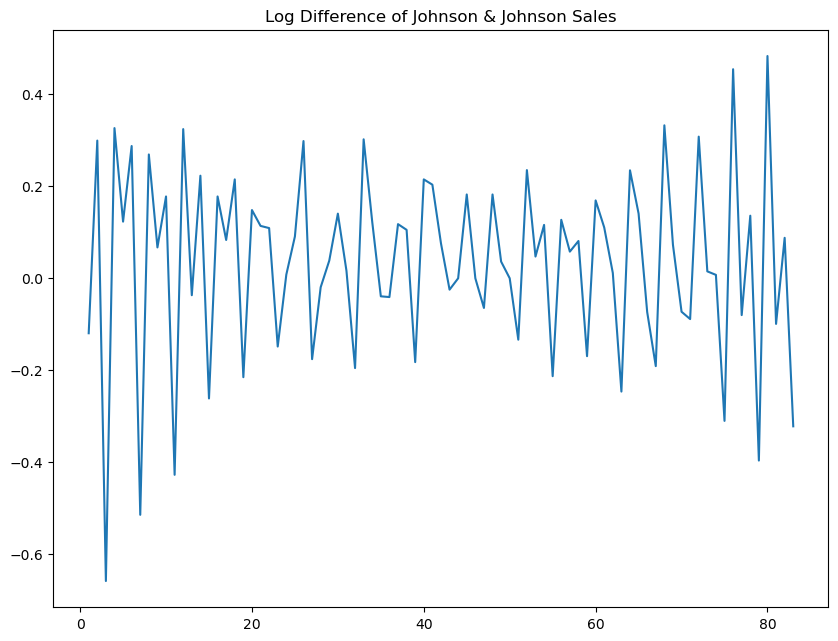

In [ ]:
# plot the log difference
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Johnson & Johnson Sales")
plt.show()

In [ ]:
# re-run the ADF test
ad_fuller_result = adfuller(data['data_tr_1'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811826
p-value: 0.0004149731404440838


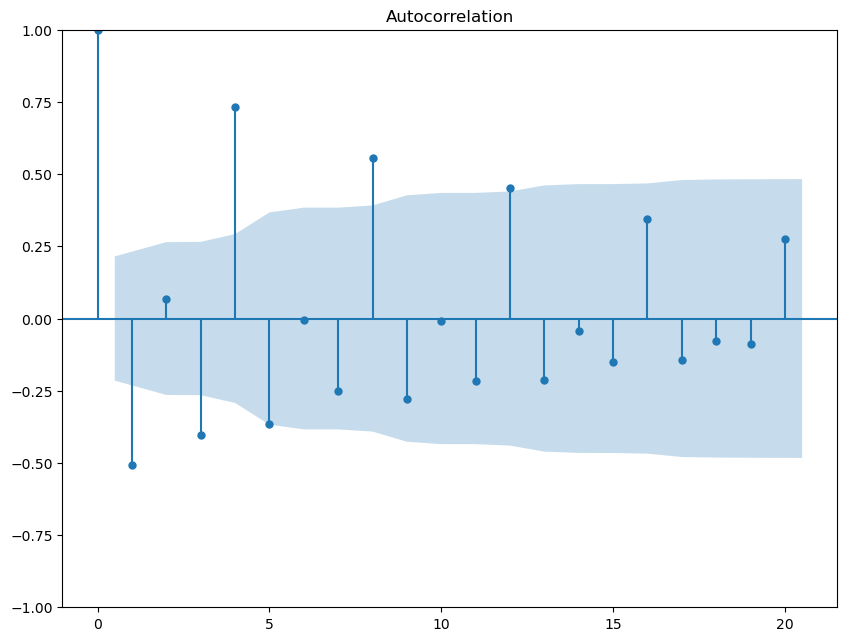

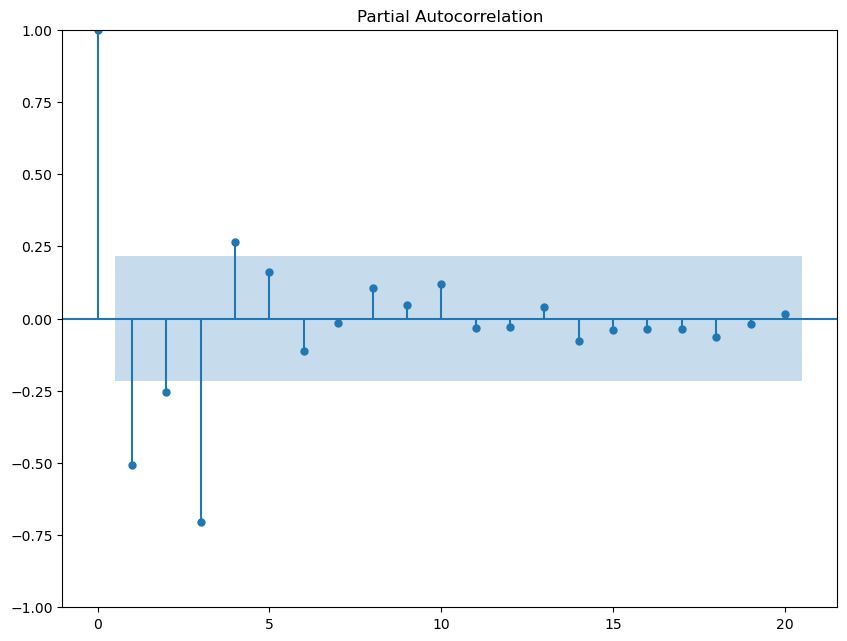

In [ ]:
# plot the ACF and PACF
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);
plt.show()

In [ ]:
# define model

from statsmodels.tsa.arima.model import ARIMA
# p,d,q ARIMA Model
#model = ARIMA(y, order=(1,0,1))
#model is a particular model with the p,d,q parameters specified
model = ARIMA(data['data'], order=(3,1,3))
# record teh best model fit in a parameter called model_fit
model_fit = model.fit()

In [229]:
# Print the statistical summary of the fitted SARIMAX/ARIMA model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -76.286
Date:                Fri, 11 Apr 2025   AIC                            166.572
Time:                        13:27:24   BIC                            183.504
Sample:                             0   HQIC                           173.374
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0311      0.036    -28.922      0.000      -1.101      -0.961
ar.L2         -1.0273      0.043    -23.890      0.000      -1.112      -0.943
ar.L3         -0.9768      0.030    -32.181      0.0

In [ ]:
# I have used tqdm_notebook here to add a progress bar when the script is running

def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable, in this case data['data']
    """
    
    results = []
    # Loop through all combinations of p, d, q
    for order in tqdm_notebook(order_list):
        try: 
            #model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
        except:
            continue
            
        aic = model_fit.aic
        results.append([order, model_fit.aic])
        #print(order)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [ ]:
# in this example, I do the order up to p=q=8
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each) 
# print out the first few rows of order_list to check it looks right
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
# call opitimize_ARIMA

result_df = optimize_ARIMA(data['data'], order_list)

# print out the ordered list. The best model fit (lowest AIC) will be shown at the top
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.499079
1,"(4, 1, 6)",115.859346
2,"(7, 1, 1)",116.051882
3,"(5, 1, 3)",116.535767
4,"(5, 1, 4)",117.242710
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# p,d,q ARIMA Model
best_model = ARIMA(data['data'], order=(6,1,3))
# record teh best model fit in a parameter called model_fit
best_model_fit = best_model.fit()

In [232]:
# Print the statistical summary of the fitted SARIMAX/ARIMA model
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.750
Date:                Fri, 11 Apr 2025   AIC                            115.499
Time:                        13:30:02   BIC                            139.687
Sample:                             0   HQIC                           125.217
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4420      0.123    -11.685      0.000      -1.684      -1.200
ar.L2         -0.7324      0.147     -4.983      0.000      -1.020      -0.444
ar.L3          0.0448      0.063      0.714      0.4

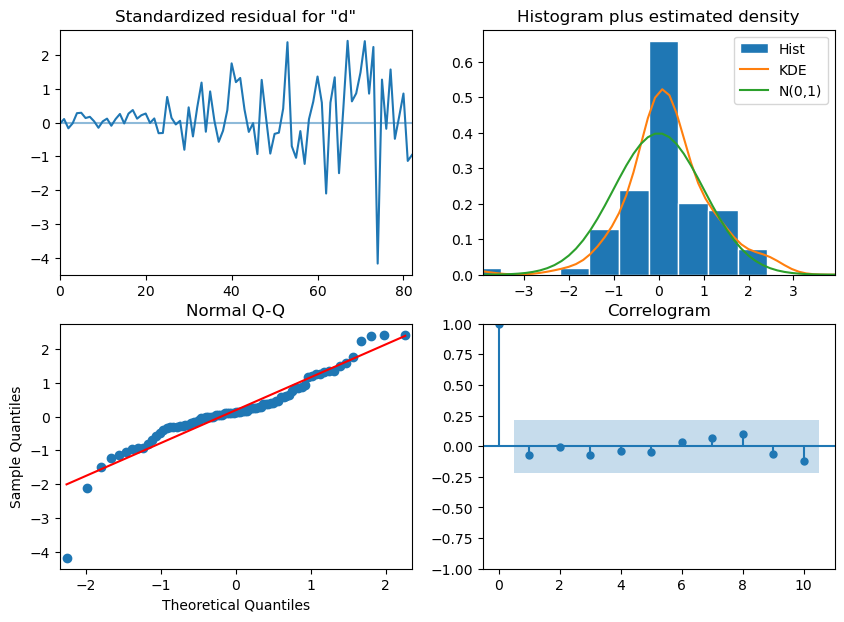

In [ ]:
# Plot diagnostic charts to evaluate model residuals (errors)
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
#get prediction start and end dates
test_data = data['data']
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

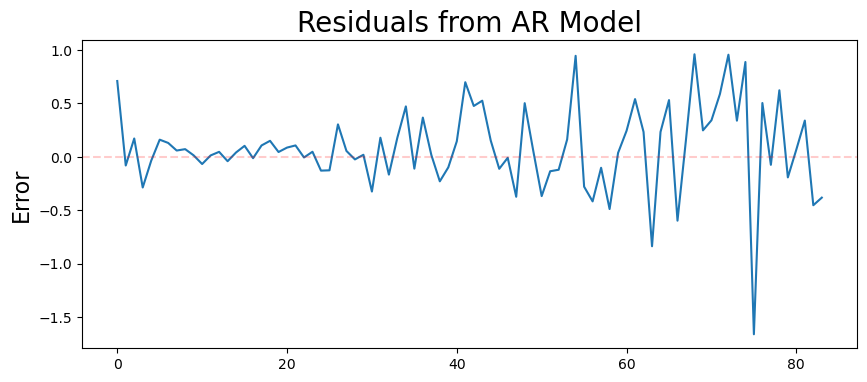

In [ ]:
# plot the residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [ ]:
# Assess the root mean square of the residuals
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.4014519180598638


Text(0.5, 0, 'Month Number')

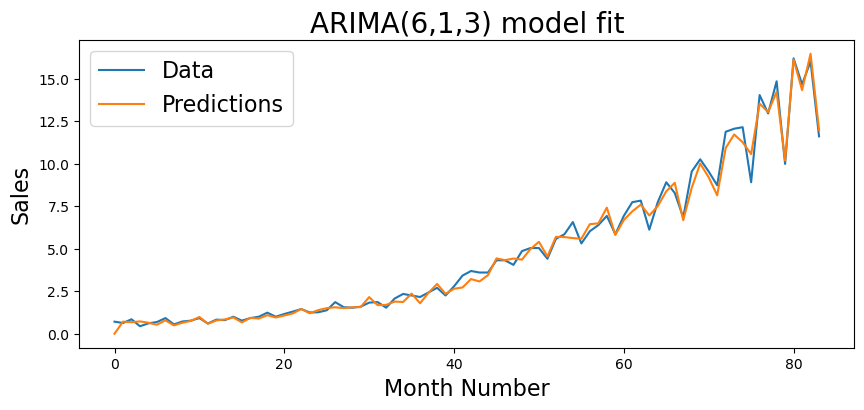

In [ ]:
# Plot the model prediction against the data
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('ARIMA(6,1,3) model fit', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)

In [ ]:
def forecast_accuracy(forecast, actual):
    # Convert to numpy arrays
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                             # ME
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    mpe = np.mean((forecast - actual) / actual)                 # MPE
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))           # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]                  # Correlation

    # Reshape before stacking
    forecast = forecast.reshape(-1, 1)
    actual = actual.reshape(-1, 1)
    mins = np.amin(np.hstack([forecast, actual]), axis=1)
    maxs = np.amax(np.hstack([forecast, actual]), axis=1)
    minmax = 1 - np.mean(mins / maxs)                           # Minmax

    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'corr': corr,
        'minmax': minmax
    }


In [ ]:
# Example usage:
forecast_accuracy(predictions, test_data)

{'mape': 0.08953174692770698,
 'me': -0.08212304061317352,
 'mae': 0.27978918370673084,
 'mpe': -0.028306925300629584,
 'rmse': 0.4014519180598638,
 'corr': 0.9957906520720566,
 'minmax': 0.08447863354817342}

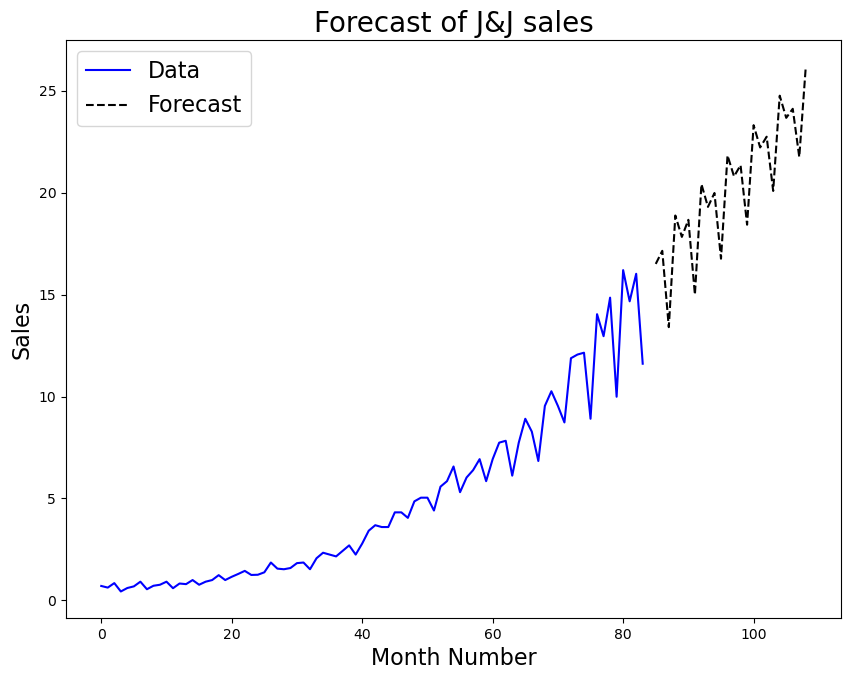

In [ ]:
# forecast version 1: get_prediction()
n_forecast = 24 #24 months
predict = best_model_fit.get_prediction(end=model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))
# this idx is to get an index to plot the forecast from teh end of teh real data
# plot
fig, ax = plt.subplots()
ax.plot(data['data'], 'blue') # plots original data
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--') #plots forecast
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)
plt.title('Forecast of J&J sales', fontsize=20)
plt.legend(('Data', 'Forecast'), fontsize=16)
plt.show()

In [205]:
# use get_forecast() for this

# make the predictions for 24 steps ahead
predictions_int = best_model_fit.get_forecast(steps=26)
predictions_int.predicted_mean

84     17.318008
85     16.505319
86     17.146921
87     13.404121
88     18.879281
89     17.830380
90     18.667666
91     14.994480
92     20.416802
93     19.301742
94     19.982448
95     16.760702
96     21.824003
97     20.796382
98     21.345389
99     18.427688
100    23.309560
101    22.217110
102    22.743642
103    20.084013
104    24.755913
105    23.668827
106    24.112733
107    21.744856
108    26.188342
109    25.105267
Name: predicted_mean, dtype: float64

In [206]:
# get a better view
predictions_int.conf_int()

,lower data,upper data
84,16.540113,18.095902
85,15.701993,17.308644
86,16.278358,18.015484
87,12.534876,14.273366
88,17.452122,20.306440
89,16.377447,19.283313
90,17.109555,20.225777
91,13.407733,16.581227
92,18.414340,22.419264
93,17.224678,21.378805


In [ ]:
# add the predicted mean column in

conf_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)
conf_df.head()

,predicted_mean,lower data,upper data
84,17.318008,16.540113,18.095902
85,16.505319,15.701993,17.308644
86,17.146921,16.278358,18.015484
87,13.404121,12.534876,14.273366
88,18.879281,17.452122,20.306440


In [208]:
# change the name of the column heads

conf_df = conf_df.rename(columns={'predicted_mean': 'Predictions', 'lower data': 'Lower CI', 'upper data': 'Upper CI'})
conf_df.head()

,Predictions,Lower CI,Upper CI
84,17.318008,16.540113,18.095902
85,16.505319,15.701993,17.308644
86,17.146921,16.278358,18.015484
87,13.404121,12.534876,14.273366
88,18.879281,17.452122,20.306440


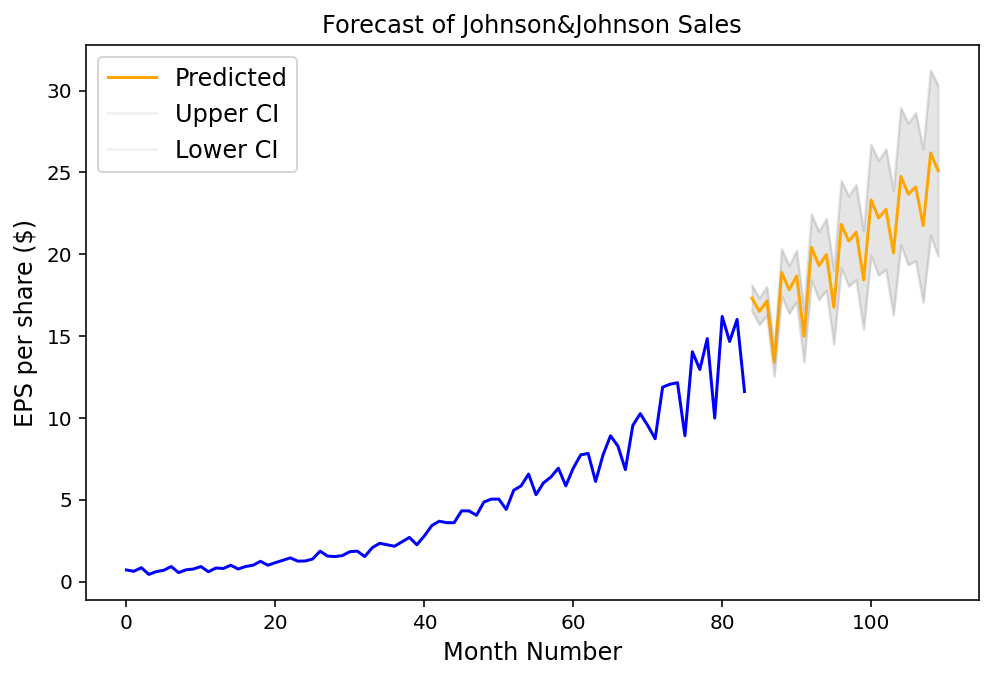

In [ ]:
# plot the forecast with confidence intervals
fig, ax = plt.subplots(figsize = (8,5), dpi=144)
ax.plot(data['data'], 'b')
#ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.set(title='Forecast of Johnson&Johnson Sales')
x = conf_df.index.values
upper = conf_df['Upper CI']
lower = conf_df['Lower CI']
conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI', alpha=0.1)
lower.plot(color = 'grey', label = 'Lower CI', alpha=0.1)

# fill between the conf intervals
ax.fill_between(x, lower, upper, color='grey', alpha=0.2)
plt.ylabel('EPS per share ($)', fontsize=12)
plt.xlabel('Month Number', fontsize=12)
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [210]:

# Load the dataset
amzn_df = pd.read_csv('AMZN.csv')

# Show the first few rows
amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


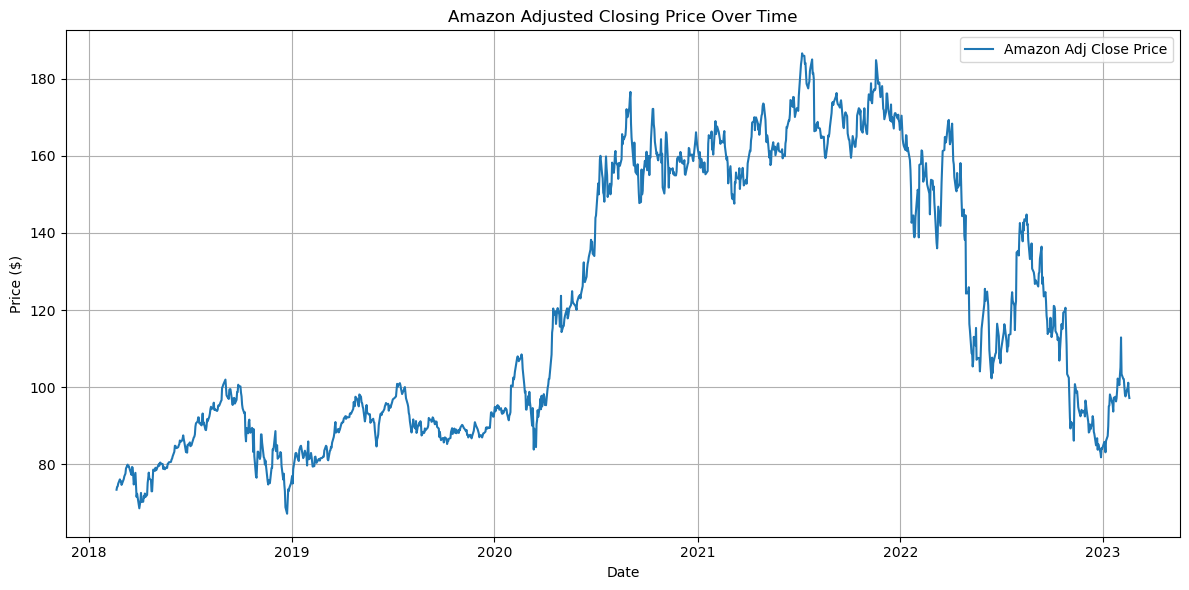

In [211]:
# Prepare the data and plot the closing price

# Convert 'Date' to datetime and set as index
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(amzn_df['Adj Close'], label='Amazon Adj Close Price')
plt.title('Amazon Adjusted Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [212]:
# Step 3: Perform the ADF test for stationarity

from statsmodels.tsa.stattools import adfuller

# Run ADF test on Adjusted Close price
adf_result_amzn = adfuller(amzn_df['Adj Close'])

# Display results
print("ADF Statistic:", adf_result_amzn[0])
print("p-value:", adf_result_amzn[1])

ADF Statistic: -1.657808991333171
p-value: 0.4529710546516684


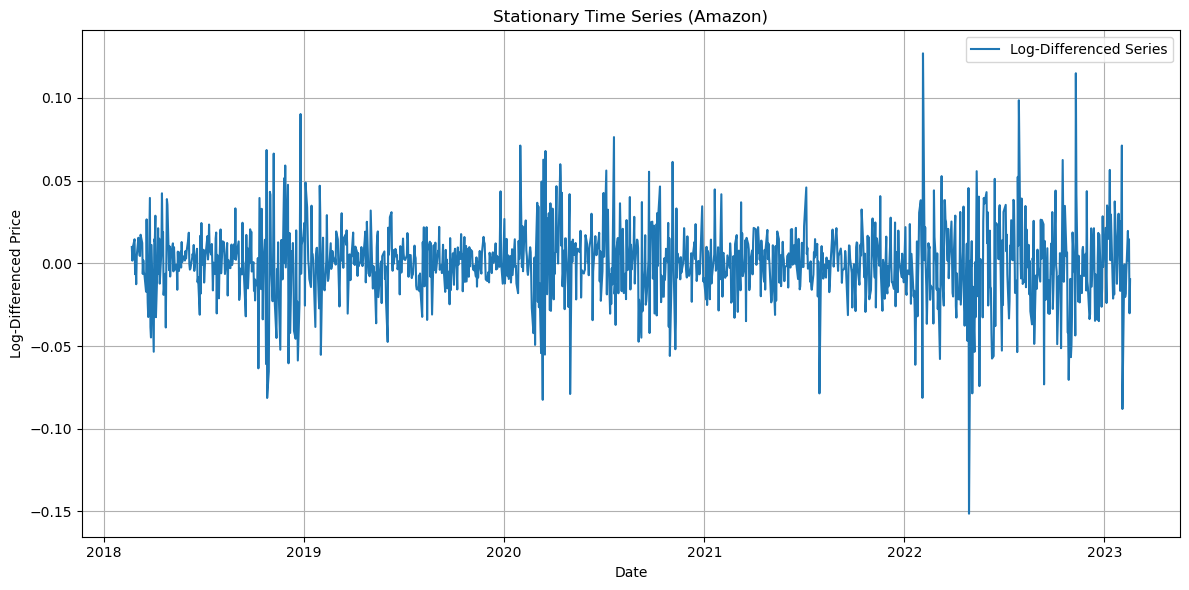

In [ ]:
#Make the series stationary (log transform + differencing)
# Apply log transformation
amzn_df['log_price'] = np.log(amzn_df['Adj Close'])

# Apply first-order differencing
amzn_df['log_diff'] = amzn_df['log_price'].diff().dropna()

# Drop NA values for clean plotting
log_diff_series = amzn_df['log_diff'].dropna()

# Plot the transformed series
plt.figure(figsize=(12, 6))
plt.plot(log_diff_series, label='Log-Differenced Series')
plt.title('Stationary Time Series (Amazon)')
plt.xlabel('Date')
plt.ylabel('Log-Differenced Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [214]:
#ADF test on log-differenced series to confirm stationarity
adf_result_log_diff = adfuller(log_diff_series)

# Display results
print("ADF Statistic:", adf_result_log_diff[0])
print("p-value:", adf_result_log_diff[1])

ADF Statistic: -36.639832812749404
p-value: 0.0


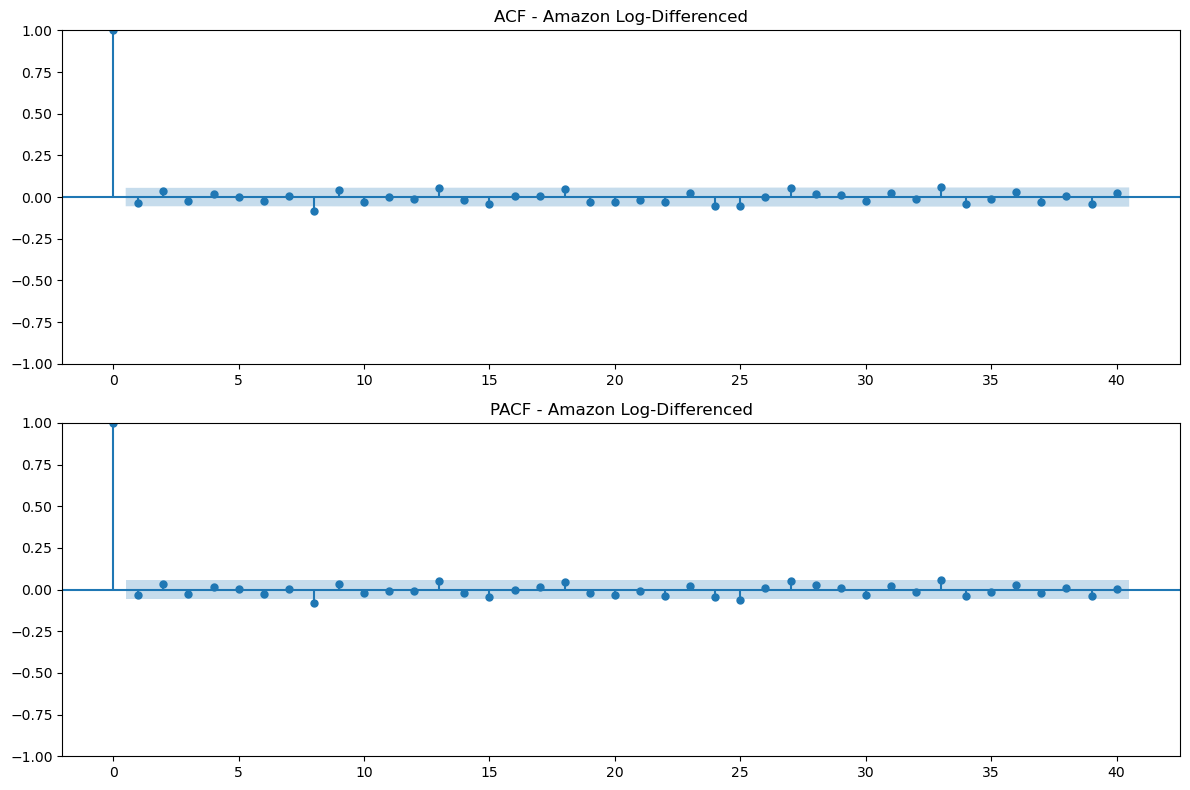

In [215]:
#ACF and PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(log_diff_series, ax=ax[0], lags=40)
plot_pacf(log_diff_series, ax=ax[1], lags=40)
ax[0].set_title('ACF - Amazon Log-Differenced')
ax[1].set_title('PACF - Amazon Log-Differenced')
plt.tight_layout()
plt.show()

In [216]:
# Manual grid search to find best ARIMA(p,d,q) using AIC
# Define the range for p, d, q
p = d = q = range(0, 4)
pdq_combinations = list(itertools.product(p, [1], q))  # d=1 due to first differencing

best_aic = float('inf')
best_order = None
best_model = None

# Fit ARIMA models and record AIC
for order in pdq_combinations:
    try:
        model = ARIMA(amzn_df['log_price'], order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

best_order, best_aic

((0, 1, 0), -5940.3401789290565)

In [ ]:
# Import the pmdarima library for automated ARIMA model selection
import pmdarima as pm

# Fit an auto ARIMA model on the log-transformed Amazon price series
auto_model = pm.auto_arima(amzn_df['log_price'], seasonal=False, stepwise=True, suppress_warnings=True)
# Print the best (p, d, q) order selected by auto_arima
print("Auto ARIMA Order:", auto_model.order)
# Print the AIC (Akaike Information Criterion) for the selected model
print("AIC:", auto_model.aic())

Auto ARIMA Order: (0, 1, 0)
AIC: -5940.3401789290565


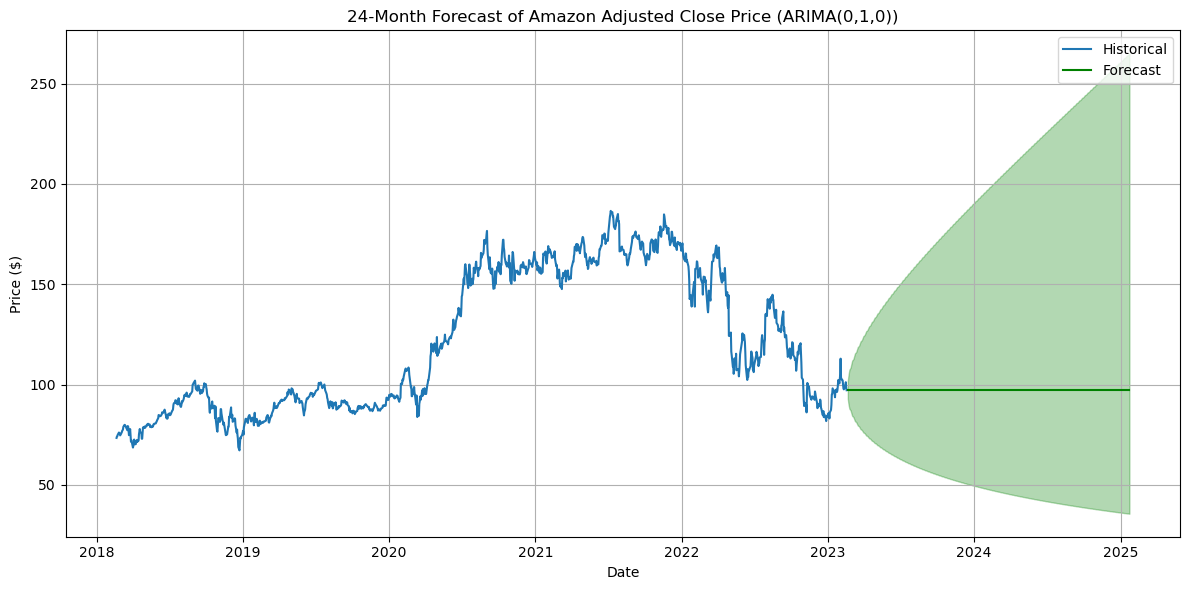

2023-02-20    97.199997
2023-02-21    97.199997
2023-02-22    97.199997
2023-02-23    97.199997
2023-02-24    97.199997
Freq: B, Name: predicted_mean, dtype: float64

In [218]:

#Fit the best model (ARIMA(0,1,0)) and forecast 24 months (approx. 504 trading days)

# Fit the model
model_010 = ARIMA(amzn_df['log_price'], order=(0, 1, 0)).fit()

# Forecast the next 504 days (~24 months of trading days)
forecast_steps = 504
forecast_result = model_010.get_forecast(steps=forecast_steps)
forecast_log_mean = forecast_result.predicted_mean
forecast_log_ci = forecast_result.conf_int()

# Convert forecast back to original scale
forecast_mean = np.exp(forecast_log_mean)
forecast_ci = np.exp(forecast_log_ci)

# Create future date range
last_date = amzn_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')  # 'B' for business days
forecast_mean.index = future_dates
forecast_ci.index = future_dates

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(amzn_df['Adj Close'], label='Historical')
plt.plot(forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='green', alpha=0.3)
plt.title('24-Month Forecast of Amazon Adjusted Close Price (ARIMA(0,1,0))')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

forecast_mean.head()


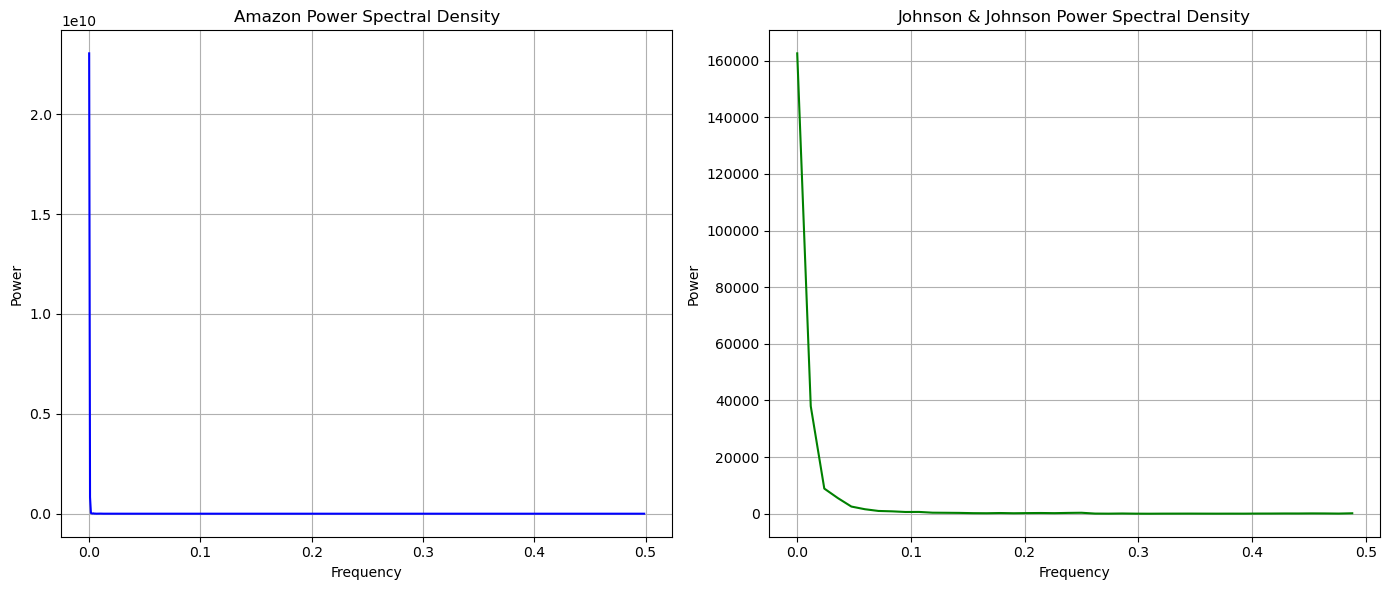

In [228]:
# --- Apply FFT to both datasets ---

# Assuming 'Close' for Amazon and 'Sales' for J&J
amazon_series = amzn_data['Close'].values
jj_series = data['data'].values

# Number of samples
N_amzn = len(amazon_series)
N_jj = len(jj_series)

# Apply FFT
fft_amzn = fft(amazon_series)
fft_jj = fft(jj_series)

# Frequency axis
freqs_amzn = fftfreq(N_amzn)
freqs_jj = fftfreq(N_jj)

# Power Spectral Density
psd_amzn = np.abs(fft_amzn) ** 2
psd_jj = np.abs(fft_jj) ** 2

# --- Plotting PSD (Periodogram) ---

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(freqs_amzn[:N_amzn//2], psd_amzn[:N_amzn//2], color='blue')
plt.title("Amazon Power Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(freqs_jj[:N_jj//2], psd_jj[:N_jj//2], color='green')
plt.title("Johnson & Johnson Power Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)

plt.tight_layout()
plt.show()

LSTM 

Epoch 1/50
31/31 [==============================] - 3s 31ms/step - loss: 0.0669 - val_loss: 0.0112
Epoch 2/50
31/31 [==============================] - 1s 22ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 3/50
31/31 [==============================] - 1s 22ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 4/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 5/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 6/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 7/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 8/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 9/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 10/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 11/

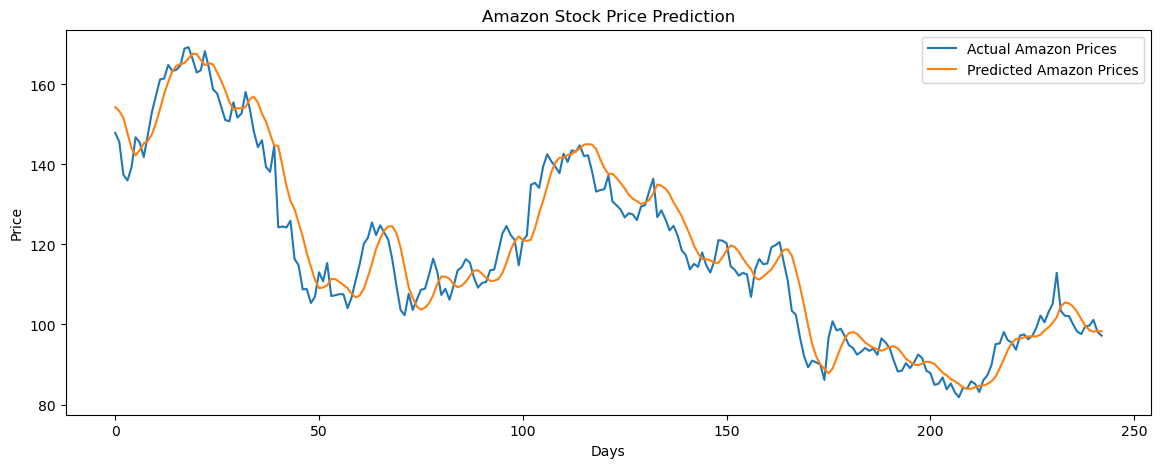

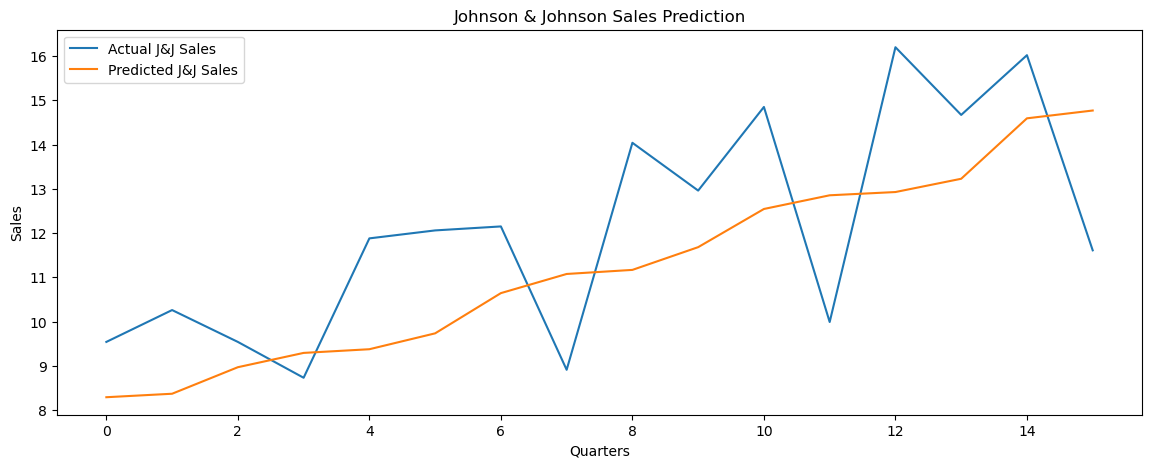

In [219]:
# Load datasets
amazon_df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
jj_df = pd.read_csv('jj.csv', parse_dates=['date'], index_col='date')

amazon_close = amazon_df[['Close']]
jj_sales = jj_df.rename(columns={'data': 'Sales'})[['Sales']]

# Function for creating sequences for LSTM
def prepare_lstm_data(data, time_steps):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i - time_steps:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    return np.reshape(X, (X.shape[0], X.shape[1], 1)), y, scaler

# Prepare sequences (optimized)
amazon_X, amazon_y, amazon_scaler = prepare_lstm_data(amazon_close, 45)
jj_X, jj_y, jj_scaler = prepare_lstm_data(jj_sales, 6)

# Split data into training and testing sets
def split_data(X, y, split_ratio=0.8):
    split_idx = int(len(X) * split_ratio)
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

amazon_X_train, amazon_X_test, amazon_y_train, amazon_y_test = split_data(amazon_X, amazon_y)
jj_X_train, jj_X_test, jj_y_train, jj_y_test = split_data(jj_X, jj_y)

# Optimized LSTM Model
def optimized_lstm(X_train):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train models
amazon_model = optimized_lstm(amazon_X_train)
amazon_model.fit(amazon_X_train, amazon_y_train, epochs=50, batch_size=32, validation_data=(amazon_X_test, amazon_y_test))

jj_model = optimized_lstm(jj_X_train)
jj_model.fit(jj_X_train, jj_y_train, epochs=50, batch_size=8, validation_data=(jj_X_test, jj_y_test))

# Predictions
amazon_preds = amazon_scaler.inverse_transform(amazon_model.predict(amazon_X_test))
amazon_actual = amazon_scaler.inverse_transform(amazon_y_test.reshape(-1, 1))

jj_preds = jj_scaler.inverse_transform(jj_model.predict(jj_X_test))
jj_actual = jj_scaler.inverse_transform(jj_y_test.reshape(-1, 1))

# Evaluation Metrics
def evaluate_predictions(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

amazon_rmse, amazon_mae, amazon_mape = evaluate_predictions(amazon_actual, amazon_preds)
jj_rmse, jj_mae, jj_mape = evaluate_predictions(jj_actual, jj_preds)

print(f'Amazon RMSE: {amazon_rmse:.4f}, MAE: {amazon_mae:.4f}, MAPE: {amazon_mape:.2f}%')
print(f'Johnson & Johnson RMSE: {jj_rmse:.4f}, MAE: {jj_mae:.4f}, MAPE: {jj_mape:.2f}%')

# Visualization
plt.figure(figsize=(14,5))
plt.plot(amazon_actual, label='Actual Amazon Prices')
plt.plot(amazon_preds, label='Predicted Amazon Prices')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(jj_actual, label='Actual J&J Sales')
plt.plot(jj_preds, label='Predicted J&J Sales')
plt.title('Johnson & Johnson Sales Prediction')
plt.xlabel('Quarters')
plt.ylabel('Sales')
plt.legend()
plt.show()


1/1 [==============================] - 0s 30ms/step


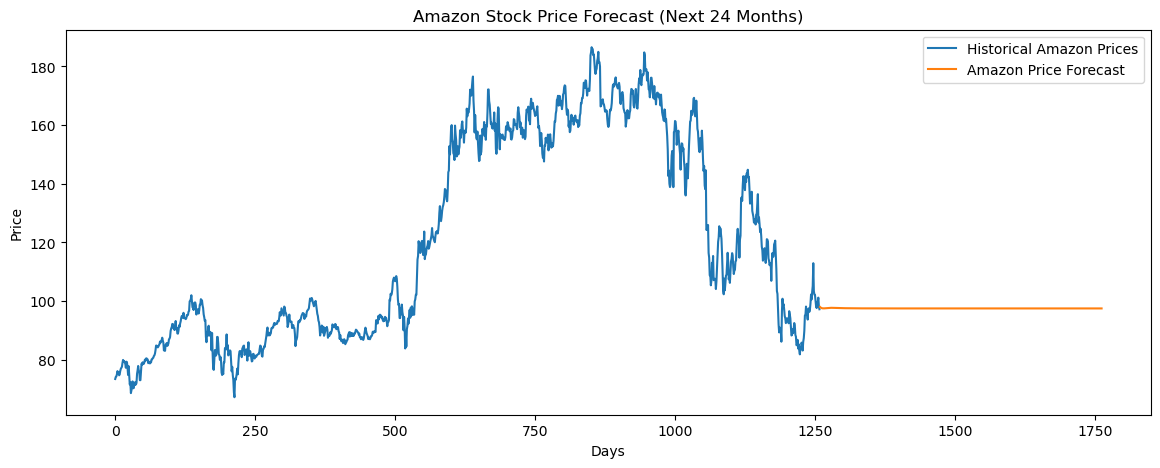

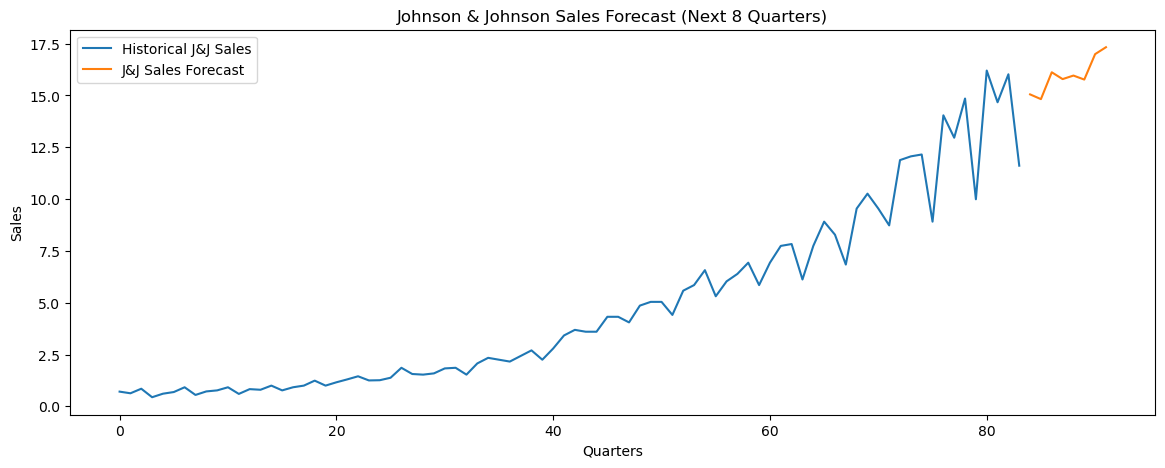

In [220]:
# Forecasting function for future predictions
def forecast_future(model, recent_data, scaler, steps):
    predictions = []
    current_data = recent_data.copy()

    for _ in range(steps):
        pred = model.predict(current_data.reshape(1, -1, 1))
        predictions.append(pred[0, 0])
        current_data = np.roll(current_data, -1)
        current_data[-1] = pred

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Amazon Stock: Forecast for 24 months (~504 trading days)
amazon_future_steps = 504
amazon_recent_data = amazon_scaler.transform(amazon_close.values[-45:])
amazon_forecast = forecast_future(amazon_model, amazon_recent_data.flatten(), amazon_scaler, amazon_future_steps)

# Johnson & Johnson: Forecast for 8 quarters (2 years)
jj_future_steps = 8
jj_recent_data = jj_scaler.transform(jj_sales.values[-6:])
jj_forecast = forecast_future(jj_model, jj_recent_data.flatten(), jj_scaler, jj_future_steps)

# Visualization of Amazon Forecast
plt.figure(figsize=(14,5))
plt.plot(range(len(amazon_close)), amazon_close, label='Historical Amazon Prices')
plt.plot(range(len(amazon_close), len(amazon_close) + amazon_future_steps), amazon_forecast, label='Amazon Price Forecast')
plt.title('Amazon Stock Price Forecast (Next 24 Months)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Visualization of Johnson & Johnson Forecast
plt.figure(figsize=(14,5))
plt.plot(range(len(jj_sales)), jj_sales, label='Historical J&J Sales')
plt.plot(range(len(jj_sales), len(jj_sales) + jj_future_steps), jj_forecast, label='J&J Sales Forecast')
plt.title('Johnson & Johnson Sales Forecast (Next 8 Quarters)')
plt.xlabel('Quarters')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [221]:
# Evaluation Metrics Function
def evaluate_predictions(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

# Evaluate Test Predictions (Historical Test Data)
amazon_rmse, amazon_mae, amazon_mape = evaluate_predictions(amazon_actual, amazon_preds)
jj_rmse, jj_mae, jj_mape = evaluate_predictions(jj_actual, jj_preds)

print(f"Amazon Test Data Metrics:")
print(f"RMSE: {amazon_rmse:.4f}")
print(f"MAE: {amazon_mae:.4f}")
print(f"MAPE: {amazon_mape:.2f}%\n")

print(f"Johnson & Johnson Test Data Metrics:")
print(f"RMSE: {jj_rmse:.4f}")
print(f"MAE: {jj_mae:.4f}")
print(f"MAPE: {jj_mape:.2f}%\n")



Amazon Test Data Metrics:
RMSE: 5.9169
MAE: 4.6672
MAPE: 4.02%

Johnson & Johnson Test Data Metrics:
RMSE: 2.1308
MAE: 1.9625
MAPE: 16.36%

